In [27]:
import pandas as pd
import numpy as np
from configparser import ConfigParser
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import unidecode
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

In [28]:
# establish sql engine connection
parser = ConfigParser()
parser.read('nb.ini')
conn_string = parser.get('my_db', 'conn_string')
engine = create_engine(conn_string)

In [29]:
sql = '''
    SELECT COUNT(*)
    FROM statcast_2021
    WHERE home_team = 'CWS' or away_team = 'CWS'
'''

results = engine.execute(sql)
engine.dispose()
rows = results.fetchall()

for row in rows:
    print(row)

(48938,)


In [30]:
# fetch White Sox data from postgresql database

sql1 = '''
    SELECT *
    FROM statcast_2019
    WHERE home_team = 'CWS' or away_team = 'CWS'
'''

cws_19 = pd.read_sql_query(sql1, engine)

sql2 = '''
    SELECT *
    FROM statcast_2020
    WHERE home_team = 'CWS' or away_team = 'CWS'
'''

cws_20 = pd.read_sql_query(sql2, engine)

sql3 = '''
    SELECT *
    FROM statcast_2021
    WHERE home_team = 'CWS' or away_team = 'CWS'
'''

cws_21 = pd.read_sql_query(sql3, engine)

In [31]:
# set relevant columns, concatenate 2019 through 2021 data

cols = ['player_name', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x', 
         'release_pos_y', 'release_pos_z', 'release_spin_rate', 'release_extension', 
         'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'vx0',
         'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed',
         'pitch_name', 'spin_axis']

cws_19_ft = cws_19[cols]
cws_20_ft = cws_20[cols]
cws_21_ft = cws_21[cols]

cws_ft = pd.concat([cws_19_ft, cws_20_ft, cws_21_ft])

cws_ft

,player_name,pitch_type,game_date,release_speed,release_pos_x,release_pos_y,release_pos_z,release_spin_rate,release_extension,pfx_x,...,plate_z,vx0,vy0,vz0,ax,ay,az,effective_speed,pitch_name,spin_axis
0,"Detwiler, Ross",FF,2019-09-29,90.8,1.70,55.38,6.54,2229.0,5.1,0.70,...,2.72,-6.320060,-131.856935,-6.652703,9.092417,26.618561,-13.781079,88.9,4-Seam Fastball,156.0
1,"Detwiler, Ross",FF,2019-09-29,90.9,1.69,55.19,6.54,2150.0,5.3,0.87,...,2.61,-6.163837,-131.947154,-6.807185,11.107123,27.199879,-14.601518,89.2,4-Seam Fastball,149.0
2,"Detwiler, Ross",FF,2019-09-29,90.5,1.79,55.25,6.56,2257.0,5.2,0.74,...,3.73,-6.465599,-131.532339,-4.017770,9.627689,26.339513,-15.425408,88.9,4-Seam Fastball,153.0
3,"Herrera, Kelvin",FC,2019-09-29,91.1,-2.16,54.71,6.08,2347.0,5.8,-0.05,...,1.02,5.659540,-132.261173,-7.523466,-1.822484,29.552101,-26.184787,89.9,Cutter,187.0
4,"Herrera, Kelvin",FC,2019-09-29,88.2,-2.22,54.78,6.07,2366.0,5.7,0.19,...,2.29,5.356255,-128.270061,-3.958404,0.855951,27.381318,-26.670237,87.1,Cutter,158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48933,"Bundy, Dylan",SL,2021-04-01 00:00:00,80.6,-2.19,54.65,6.22,2883.0,5.8,0.42,...,4.34,3.500496,-117.325532,2.858295,3.339777,20.117864,-35.093907,80.3,Slider,51.0
48934,"Bundy, Dylan",SI,2021-04-01 00:00:00,92.3,-2.04,54.35,6.31,2575.0,6.1,-1.26,...,2.54,4.818720,-134.219390,-6.564692,-16.326358,29.144684,-15.376335,92.0,Sinker,199.0
48935,"Bundy, Dylan",SL,2021-04-01 00:00:00,80.0,-2.32,54.64,6.18,2842.0,5.9,0.71,...,2.65,2.316856,-116.614394,-0.511918,6.054594,21.557781,-35.151147,79.6,Slider,26.0
48936,"Bundy, Dylan",SL,2021-04-01 00:00:00,79.8,-2.36,54.60,6.16,2671.0,5.9,0.49,...,2.70,3.053576,-116.159204,-0.225082,3.838962,21.948125,-35.444980,79.2,Slider,50.0


In [32]:
cws_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114967 entries, 0 to 48937
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   player_name        114967 non-null  object 
 1   pitch_type         114627 non-null  object 
 2   game_date          114967 non-null  object 
 3   release_speed      114372 non-null  float64
 4   release_pos_x      114369 non-null  float64
 5   release_pos_y      114369 non-null  float64
 6   release_pos_z      114369 non-null  float64
 7   release_spin_rate  113624 non-null  float64
 8   release_extension  114290 non-null  float64
 9   pfx_x              114369 non-null  float64
 10  pfx_z              114369 non-null  float64
 11  plate_x            114369 non-null  float64
 12  plate_z            114369 non-null  float64
 13  vx0                114369 non-null  float64
 14  vy0                114369 non-null  float64
 15  vz0                114369 non-null  float64
 16  ax 

In [33]:
# remove accents from letters

cws_ft['player_name'] = cws_ft['player_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [34]:
# filter for starting pitchers

st_pitchers = cws_ft['player_name'].isin(['Cease, Dylan', 'Giolito, Lucas', 'Lynn, Lance', 'Rodon, Carlos', 'Keuchel, Dallas'])
cws_st_pitchers = cws_ft.loc[st_pitchers]

In [35]:
# confirm starting pitchers

cws_st_pitchers['player_name'].unique()

array(['Cease, Dylan', 'Giolito, Lucas', 'Keuchel, Dallas', 'Lynn, Lance',
       'Rodon, Carlos'], dtype=object)

### Data Exploration

In [36]:
# print dataset summary

cws_st_pitchers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22420 entries, 2410 to 48920
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        22420 non-null  object 
 1   pitch_type         22315 non-null  object 
 2   game_date          22420 non-null  object 
 3   release_speed      22315 non-null  float64
 4   release_pos_x      22315 non-null  float64
 5   release_pos_y      22315 non-null  float64
 6   release_pos_z      22315 non-null  float64
 7   release_spin_rate  22247 non-null  float64
 8   release_extension  22293 non-null  float64
 9   pfx_x              22315 non-null  float64
 10  pfx_z              22315 non-null  float64
 11  plate_x            22315 non-null  float64
 12  plate_z            22315 non-null  float64
 13  vx0                22315 non-null  float64
 14  vy0                22315 non-null  float64
 15  vz0                22315 non-null  float64
 16  ax                 

In [37]:
# identify null percentages

cws_st_pitchers.isnull().sum()/len(cws_st_pitchers)

player_name          0.000000
pitch_type           0.004683
game_date            0.000000
release_speed        0.004683
release_pos_x        0.004683
release_pos_y        0.004683
release_pos_z        0.004683
release_spin_rate    0.007716
release_extension    0.005665
pfx_x                0.004683
pfx_z                0.004683
plate_x              0.004683
plate_z              0.004683
vx0                  0.004683
vy0                  0.004683
vz0                  0.004683
ax                   0.004683
ay                   0.004683
az                   0.004683
effective_speed      0.004683
pitch_name           0.004683
spin_axis            0.005665
dtype: float64

In [38]:
# drop all nulls - won't lose anything

cws_st_pitchers = cws_st_pitchers.dropna()

In [39]:
# confirm data types

cws_st_pitchers.dtypes

player_name           object
pitch_type            object
game_date             object
release_speed        float64
release_pos_x        float64
release_pos_y        float64
release_pos_z        float64
release_spin_rate    float64
release_extension    float64
pfx_x                float64
pfx_z                float64
plate_x              float64
plate_z              float64
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
effective_speed      float64
pitch_name            object
spin_axis            float64
dtype: object

In [40]:
# convert game date to pd.datetime type

cws_st_pitchers['game_date'] =  pd.to_datetime(cws_st_pitchers['game_date'])

In [41]:
# what does our target variable look like? 

print(cws_st_pitchers['pitch_type'].unique())
print(cws_st_pitchers['pitch_name'].unique())

['SL' 'FF' 'FT' 'CH' 'KC' 'CU' 'FC' 'SI']
['Slider' '4-Seam Fastball' '2-Seam Fastball' 'Changeup' 'Knuckle Curve'
 'Curveball' 'Cutter' 'Sinker']


In [42]:
from sklearn.model_selection import train_test_split

# set feature and target arrays
X, y = cws_st_pitchers.drop(["pitch_type", "pitch_name", "game_date", "player_name"], axis=1), cws_st_pitchers["pitch_type"].values.flatten()

# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=13, test_size=0.3, stratify=y
)

In [43]:
# set up categorical and numerical pipelines
# we don't have any categorical features but set up the pipeline nonetheless

num_cols = X.select_dtypes(include='number').columns.to_list()
cat_cols = X.select_dtypes(include='object').columns.to_list()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [44]:
# set up preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)])

In [45]:
# bring pipelines together for modeling

dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', DecisionTreeClassifier())])

In [46]:
# set hyperparameter grid for tuning

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [2, 4, 6 , 8, 10, 12]

params = dict(classifier__criterion = criterion,
              classifier__splitter = splitter,
              classifier__max_depth = max_depth)

In [47]:
# fit the model

dt_clf_GS = GridSearchCV(dt_clf, params)

dt_clf_GS.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_pos_x',
                                                                          'release_pos_y',
                                                                          'release_pos_z',
                                                                          'relea

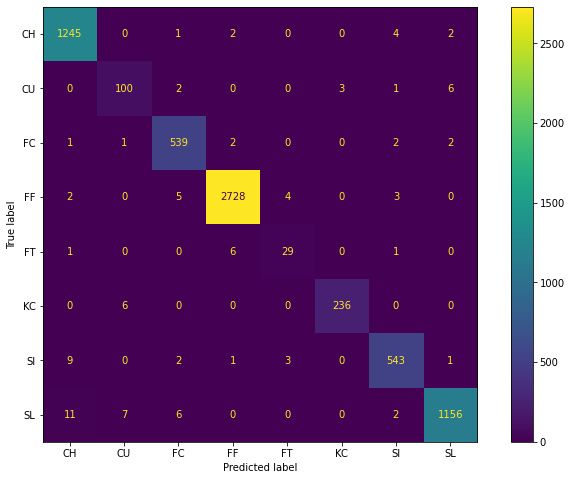

In [48]:
y_pred = dt_clf_GS.best_estimator_.predict(X_test)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=dt_clf_GS.best_estimator_.classes_)
cmp.plot(ax=ax)

plt.show()

In [49]:
print(classification_report(y_test, y_pred, target_names=dt_clf_GS.best_estimator_.classes_))

              precision    recall  f1-score   support

          CH       0.98      0.99      0.99      1254
          CU       0.88      0.89      0.88       112
          FC       0.97      0.99      0.98       547
          FF       1.00      0.99      1.00      2742
          FT       0.81      0.78      0.79        37
          KC       0.99      0.98      0.98       242
          SI       0.98      0.97      0.97       559
          SL       0.99      0.98      0.98      1182

    accuracy                           0.99      6675
   macro avg       0.95      0.95      0.95      6675
weighted avg       0.99      0.99      0.99      6675



In [50]:
# Generate scores with .predict_proba
y_pred_probs = dt_clf_GS.best_estimator_.predict_proba(X_test)

# Calculate ROC_AUC
roc_auc_score(
    y_test, y_pred_probs, multi_class="ovr", average="weighted"
  )

0.991736112001955

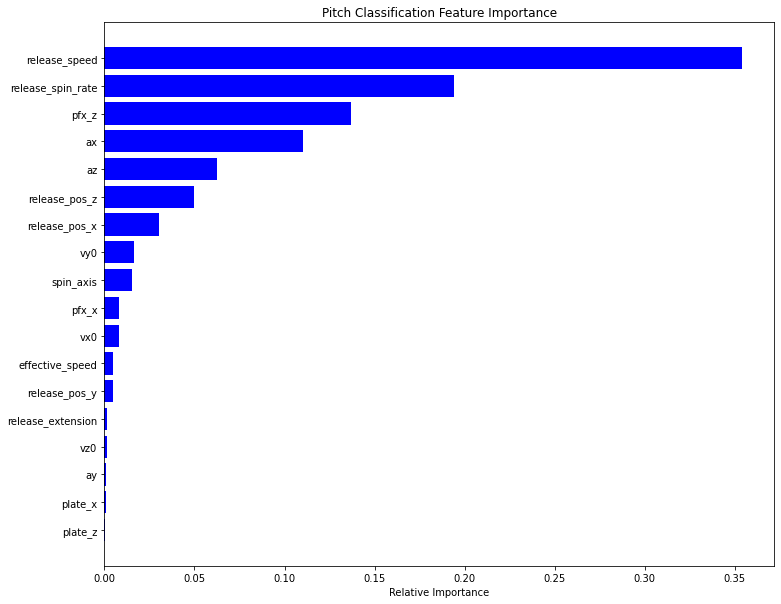

In [51]:
features = X.columns.to_list()
importances = dt_clf_GS.best_estimator_._final_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,10))
plt.title('Pitch Classification Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


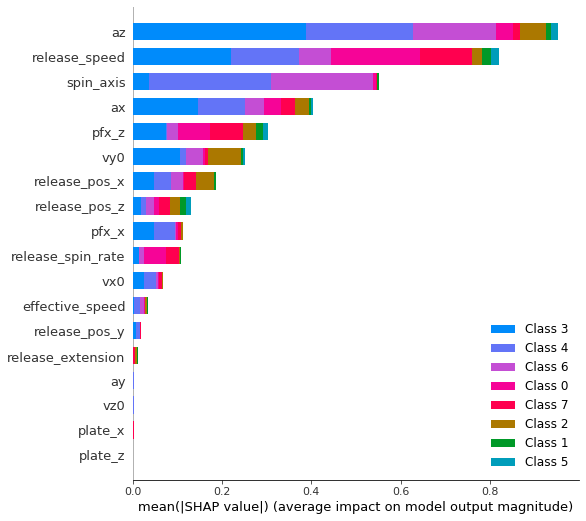

In [52]:
import shap
shap_values = shap.TreeExplainer(dt_clf_GS.best_estimator_._final_estimator).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")